In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from mpl_toolkits.mplot3d import Axes3D

path = '../output_data/'

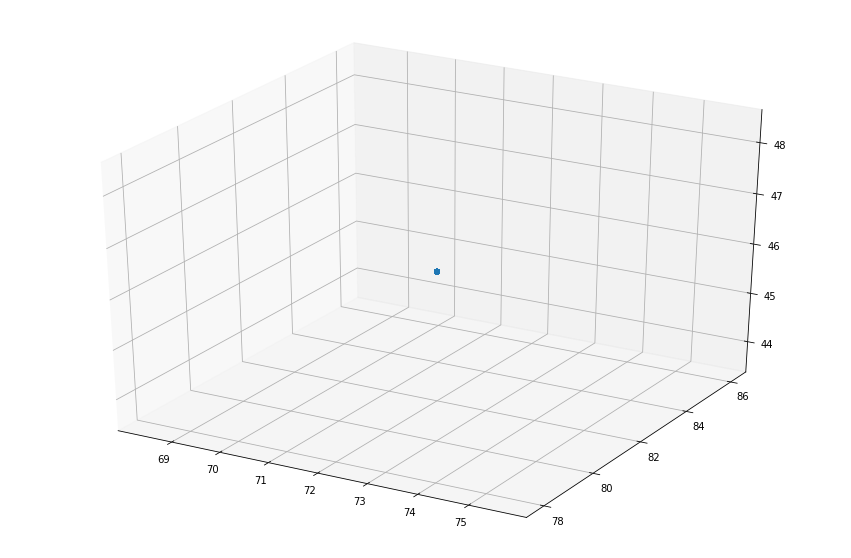

In [2]:
with pd.HDFStore(path + 'X0c.h5') as store:
    opd = store.select('dat_0')
opd.index = opd.index.droplevel(['eps', 'phi', 'test'])
opinions = opd.xs(level=1, key='opinions')
dfN = opinions
dfN_vis = pd.DataFrame(index=dfN.index)
dfN_vis['x'] = dfN['O1'] + dfN['O2'] + dfN['O3']
dfN_vis['y'] = dfN['O4'] + dfN['O5'] + dfN['O6']
dfN_vis['z'] = dfN['O7'] + dfN['O8']

dfN = dfN.reset_index().drop_duplicates(['sample']).set_index(['sample'])

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=dfN_vis[['x']], ys=dfN_vis[['y']], zs=dfN_vis['z'])

In [3]:
dfN

,O1,O2,O3,O4,O5,O6,O7,O8,sample_id
sample,,,,,,,,,
83,28.0,14.0,30.0,26.0,24.0,32.0,14.0,32.0,NaN
195,28.0,14.0,30.0,26.0,24.0,32.0,14.0,32.0,NaN
193,28.0,14.0,30.0,26.0,24.0,32.0,14.0,32.0,NaN
31,28.0,14.0,30.0,26.0,24.0,32.0,14.0,32.0,NaN
107,28.0,14.0,30.0,26.0,24.0,32.0,14.0,32.0,NaN
15,28.0,14.0,30.0,26.0,24.0,32.0,14.0,32.0,NaN
131,28.0,14.0,30.0,26.0,24.0,32.0,14.0,32.0,NaN
79,28.0,14.0,30.0,26.0,24.0,32.0,14.0,32.0,NaN
227,28.0,14.0,30.0,26.0,24.0,32.0,14.0,32.0,NaN


In [4]:
with pd.HDFStore(path + 'X0c.h5') as store:
    trj = store.select('dat_1')
trj.index = trj.index.droplevel(['eps', 'phi', 'test'])
trj = trj.reset_index().drop_duplicates(['sample', 'tstep']).set_index(['sample', 'tstep'])

In [5]:
cond = pd.DataFrame(index=trj.index)
cond['a'] = trj['K_c']/trj['K_d'] - 0.15276374882897656
cond['b'] = trj['i_c']
cond['c'] = trj['r_c']

# cond['d'] = np.sqrt((cond['a'])**2)
# cond['d'].unstack('sample').loc[:9].sum(axis=0)

In [6]:
t_max=9.

# calculate point distance
cond['d'] = np.sqrt((cond['a'])**2)

# sum over point distance for each trajectory
dfN['distance'] = cond['d'].unstack('sample').loc[:t_max].sum(axis=0)*25

# map distances to interval (0,1]
dfN['inv_distance'] = 1./(1. + dfN['distance'])

# use 1/distance as weight
dfN['weight'] = 1/cond['d'].unstack('sample').loc[:t_max].sum(axis=0)
dfN['weight'] = dfN['weight']/sum(dfN['weight'].values)

for s in dfN.index.values:
    cond.loc[s, 'inv_distance'] = dfN.loc[s, 'inv_distance']
dfN['weight'].sum()
cond.head()

a         b         c         d  inv_distance
sample tstep                                                      
83     0.0    0.000007  0.525383  0.062928  0.000007      0.148447
       1.0    0.001961  0.169599  0.064340  0.001961      0.148447
       2.0    0.005493  0.194523  0.065814  0.005493      0.148447
       3.0    0.010005  0.199328  0.067239  0.010005      0.148447
       4.0    0.012379  0.169397  0.068592  0.012379      0.148447

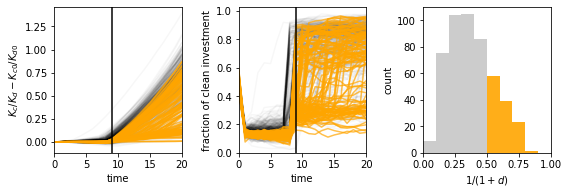

In [7]:
from collections import Counter
fig, axes = plt.subplots(ncols=3, figsize=(8, 2.8))

def plot_cond(df, c, ax, t_max, thresh=0.5):
    tmp = df
    tmp1 = tmp[[c]].loc[tmp['inv_distance']<thresh]
    tmp2 = tmp[[c]].loc[tmp['inv_distance']>thresh]
    tmp1.unstack('sample').loc[:t_max].plot(ax=ax, alpha=.03, legend=False, color=['k'])
    tmp2.unstack('sample').loc[:t_max].plot(ax=ax, legend=False, alpha=.7, color=['orange'])
    
thresh=0.5

plot_cond(cond, 'a', axes[0], 20, thresh=thresh)
plot_cond(cond, 'b', axes[1], 20, thresh=thresh)

dfN['inv_distance'].loc[dfN['inv_distance']>thresh].plot.hist(ax=axes[2], color=['orange'], alpha=0.9, bins=0.1*np.arange(5,11))
dfN['inv_distance'].loc[dfN['inv_distance']<thresh].plot.hist(ax=axes[2], color=['k'], alpha=0.2, bins=0.1*np.arange(0,6))

# hist_data = pd.DataFrame(index=dfN.index)
# hist_data.loc[dfN['inv_distance']<thresh, 'classification'] = 'below'
# hist_data.loc[dfN['inv_distance']>thresh, 'classification'] = 'above'

# cnt = Counter(hist_data['classification'])

# keys1 = ['below', 'above']
# keys2 = ['above', 'below']
# keys=keys2

# axes[2].bar(keys, [cnt[k] for k in keys])

# indexes = np.arange(len(keys))

# # add labels
# plt.xticks(indexes, keys)

for ax in axes[:2]:
    ax.set_xlim([0,20])
    ax.set_xlabel('time')
    ax.axvline(t_max, color='k')

axes[0].set_ylabel(r'$K_c/K_d - K_{c0}/K_{d0}$')
axes[1].set_ylabel('fraction of clean investment')
axes[1].set_ylim((0,1.03))
axes[2].set_ylabel('count')
axes[2].set_xlabel(r'$1/(1+d)$')
axes[2].set_xlim([0,1])

fig.tight_layout()
fig.savefig('initial_condition_fitted.pdf')

In [8]:
oNames = [f'O{i+1}' for i in range(8)]

dfN_norm = pd.DataFrame(index=dfN.index, columns=dfN.columns)

for i in range(len(dfN)):
    dfN_norm.loc[i, oNames] = dfN.loc[i, oNames] * dfN['weight'][i]
dfN_norm['weight'] = dfN['weight']
print([x for x in dfN_norm.sum()])
print(sum([round(x) for x in dfN_norm[oNames].sum()]))

[28.00000000000001, 14.000000000000005, 29.99999999999997, 25.999999999999996, 24.00000000000003, 31.999999999999968, 14.000000000000005, 31.999999999999968, 0.0, 0.0, 0.0, 0.999999999999999]
200


In [9]:
sum([15, 8, 12, 12, 14, 17, 7, 16])

101

In [10]:
# initial opinions:
fitted_opinions_distribution = [15, 8, 12, 12, 14, 17, 7, 16]
x = [2 * x for x in fitted_opinions_distribution]
opinions = []

for i, xi in enumerate(x):
    opinions += int(np.round(xi)) * [i]
np.random.shuffle(opinions)
# as the fitted distribution has one count to many, I have to leave two out
# here.
opinions = opinions[:-2]

In [11]:
from collections import Counter
cnt = Counter(opinions)
for i in range(7):
    print(i, cnt[i])
print(cnt.keys())
print(cnt.values())

0 29
1 16
2 24
3 23
4 28
5 34
6 14
dict_keys([7, 1, 2, 6, 0, 5, 4, 3])
dict_values([32, 16, 24, 14, 29, 34, 28, 23])


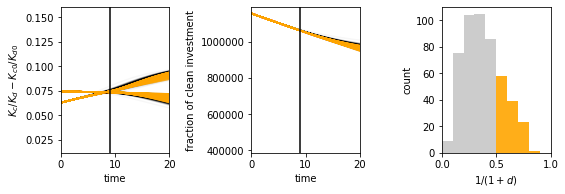

In [12]:
from collections import Counter
fig, axes = plt.subplots(ncols=3, figsize=(8, 2.8))

def plot_cond(df, c, ax, t_max, thresh=0.5, style=['-']):
    tmp = df
    tmp1 = tmp[[c]].loc[tmp['inv_distance']<thresh]
    tmp2 = tmp[[c]].loc[tmp['inv_distance']>thresh]
    tmp1.unstack('sample').loc[:t_max].plot(ax=ax, alpha=.03, legend=False, color=['k'], style=style)
    tmp2.unstack('sample').loc[:t_max].plot(ax=ax, legend=False, alpha=.7, color=['orange'], style=style)
    
thresh=0.5

trj['inv_distance'] = cond['inv_distance']

plot_cond(trj, 'r_c', axes[0], 100, thresh=thresh)
plot_cond(trj, 'r_d', axes[0], 100, thresh=thresh, style=['--'])
plot_cond(trj, 'G', axes[1], 100, thresh=thresh)

dfN['inv_distance'].loc[dfN['inv_distance']>thresh].plot.hist(ax=axes[2], color=['orange'], alpha=0.9, bins=0.1*np.arange(5,11))
dfN['inv_distance'].loc[dfN['inv_distance']<thresh].plot.hist(ax=axes[2], color=['k'], alpha=0.2, bins=0.1*np.arange(0,6))

for ax in axes[:2]:
    ax.set_xlim([0,20])
    ax.set_xlabel('time')
    ax.axvline(t_max, color='k')

axes[0].set_ylabel(r'$K_c/K_d - K_{c0}/K_{d0}$')
axes[1].set_ylabel('fraction of clean investment')
#axes[1].set_ylim((0,1.03))
axes[2].set_ylabel('count')
axes[2].set_xlabel(r'$1/(1+d)$')
axes[2].set_xlim([0,1])

fig.tight_layout()
fig.savefig('initial_condition_fitted.pdf')

In [13]:
def plot_cond(df, c, ax, t_max, thresh=0.5, c_df=None):
    tmp = df
    if c_df is None:
        c_tmp = tmp
    else:
        c_tmp = c_df
    tmp1 = tmp[[c]].loc[c_tmp>thresh]
    tmp2 = tmp[[c]].loc[c_tmp<thresh]
    try:
        tmp1.unstack('sample').loc[:t_max].plot(ax=ax, alpha=.1, legend=False, color=['#878685'])
    except TypeError:
        print('no data')
    try:
        tmp2.unstack('sample').loc[:t_max].plot(ax=ax, legend=False, alpha=.1, color=['orange'])
    except TypeError:
        print('no data')
        
def plot_hist(ax, trj, cond, t_max, indicator, cond_indicator):
    tmp = trj.xs(level='tstep', key=t_max)[[indicator]]
    tmp_cond = cond.xs(level='tstep', key=t_max)
    tmp['close'] = float('nan')
    tmp['far'] = float('nan')
    tmp.loc[tmp_cond[cond_indicator]>thresh, 'far'] = tmp.loc[tmp_cond[cond_indicator]>thresh, indicator]
    tmp.loc[tmp_cond[cond_indicator]<thresh, 'close'] = tmp.loc[tmp_cond[cond_indicator]<thresh, indicator]

    y_max = trj[indicator].max()
    y_min = trj[indicator].min()

    tmp[['close', 'far']].plot(kind='hist',
                               ax=ax,
                               stacked=True,
                               colors=['orange', '#878685'],
                               orientation='horizontal',
                               bins=np.linspace(y_min, y_max, 40),
                               legend=False)
    ax.set_ylim([y_min, y_max])
    ax.axis('off')
    return y_min, y_max

def plot_scatter(ax, trj, cond, t_scatt, indicator, cond_indicator='inv_distance', t_cond=None):
    import matplotlib.colors as cls
    
    tmp = trj.xs(level='tstep', key=t_scatt[0])[[indicator[0]]]
    tmp[indicator[1]] = trj.xs(level='tstep', key=t_scatt[1])[indicator[1]]
    tmp_cond = cond.xs(level='tstep', key=t_max)
    
    tmp['cond'] = float('nan')
    tmp.loc[tmp_cond[cond_indicator]<thresh, 'cond'] = 0
    tmp.loc[tmp_cond[cond_indicator]>thresh, 'cond'] = 1

    y_max = trj[indicator].max()
    y_min = trj[indicator].min()

    tmp.plot.scatter(x=indicator[1],
                     y=indicator[0],
                     c='cond',
                     ax=ax,
                     colormap=cls.ListedColormap(['orange', '#878685']),
                     #colors=['orange', '#878685'],
                     legend=False,
                     colorbar=False)
    #ax.set_ylim([y_min, y_max])
    #ax.axis('off')
    plt.tick_params(
        axis='both',       # changes apply to the x and y axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    
    return y_min, y_max

/home/jakob/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/plotting/_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
/home/jakob/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


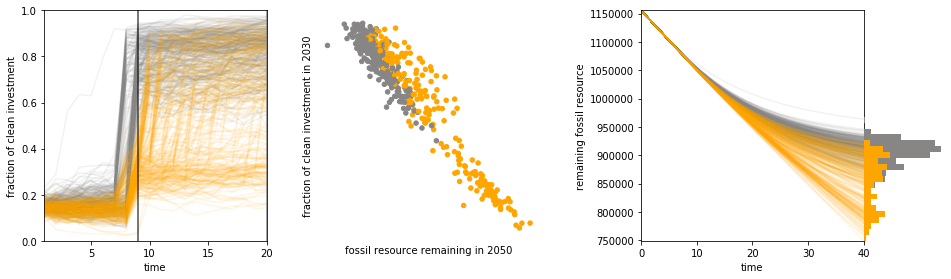

In [34]:
# setting up axes

fig = plt.figure(figsize=(14, 4))

axes = []

b_pad = .13
t_pad = .2
l_pad = .05

whist = .08
gap = .1

wplots = 1-whist-2*gap-l_pad

w1 = .33*wplots
w2 = .33*wplots
w3 = .33*wplots

l1 = l_pad
l2 = l1 + w1 + gap*.5
l3 = l2 + w2 + gap

axes.append(plt.axes((l1, b_pad, w1, 1-t_pad)))
axes.append(plt.axes((l2, b_pad, w2, 1-t_pad), frameon=False))
axes.append(plt.axes((l3, b_pad, w3, 1-t_pad)))
axes.append(plt.axes((l3 + w3, b_pad, whist, 1-t_pad)))

# setting parameters
thresh_time = 9
thresh_indicator = 'i_c'
thresh_value=0.5
t_max = 40
indicators = ['i_c', 'G']
t_scatt = [20, t_max]

for s in trj.index.levels[0]:
    cond.loc[s, thresh_indicator] = trj.loc[(s, thresh_time), thresh_indicator]

# cropping data
trj = trj.loc[(trj.reset_index()['tstep']<=t_max).values]

# plotting
plot_cond(trj, indicators[0], axes[0], t_max, thresh=thresh_value, c_df=cond[thresh_indicator])
plot_cond(trj, indicators[1], axes[2], t_max, thresh=thresh_value, c_df=cond[thresh_indicator])
y_min, y_max = plot_hist(axes[3], trj, cond, t_max, indicators[1], cond_indicator=thresh_indicator)
plot_scatter(axes[1], trj, cond, t_scatt, indicators, cond_indicator=thresh_indicator)

# fixing stuff with axes labels and ticks

axes[2].set_ylim([y_min, y_max])
axes[1].invert_xaxis()

axes[0].set_xlim([1,20])
axes[0].set_ylim([0,1])
axes[0].set_xlabel('time')
axes[0].set_ylabel(r'fraction of clean investment')
axes[0].axvline(t_scatt[0], color='#878685')
axes[0].axvline(thresh_time, color='k', alpha=.7)

axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_xlabel(f'fossil resource remaining in {2010+t_max}')
axes[1].set_ylabel(f'fraction of clean investment in {2010+t_scatt[0]}')

axes[2].set_ylabel('remaining fossil resource')
axes[2].set_xlabel('time')
axes[2].set_xlim([0, t_max])

fig.tight_layout()
fig.savefig('fitted_initials_evaluation.pdf')